# Demand Forecast

## Preamble

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

# not mandatory, but might come handy
from scipy import stats
import statsmodels.api as sm

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import add_changepoints_to_plot
from scipy.stats import pearsonr, spearmanr

import seaborn as sns
plt.style.use('default')
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Dark2')

## Data exploration

In [2]:
df = pd.read_csv('Historical Product Demand.csv')
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


### Data quality assessment

* Explore the dataset to assess its quality (nulls, skew, data types)



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


In [4]:
df.groupby('Order_Demand')['Product_Category'].count()

Order_Demand
(1)         542
(10)        259
(100)      1199
(1000)      591
(10000)      99
           ... 
996           3
997           2
998           1
99800         1
999           2
Name: Product_Category, Length: 3828, dtype: int64

In [5]:
#Remove the parenthesis () from numbers
df['Order_Demand'] = df['Order_Demand'].str.replace(")","")
df['Order_Demand'] = df['Order_Demand'].str.replace("(", "")
# df['Order_Demand'] = df['Order_Demand'].astype(int)
df.groupby('Order_Demand')['Product_Category'].count()

Order_Demand
0         28681
1           542
1         63361
10          259
10        36322
          ...  
997           2
998           1
99800         1
999           2
999000        1
Name: Product_Category, Length: 3828, dtype: int64

In [6]:
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'])
df['Date'] = pd.to_datetime(df['Date'])
df.head()


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [7]:
def summary(df): 
    table = pd.DataFrame(df.dtypes, columns = ['dtype'])
    table.reset_index(inplace = True)
    table.rename(columns = {'index': 'Name'}, inplace = True)
    table['count'] = len(df)
    table['Missing']= df.isnull().sum().values
    table['Unique'] = df.nunique().values
    table['Values'] = df.loc[0].values
    return table
summary(df) #get some basic info about the data

,Name,dtype,count,Missing,Unique,Values
0,Product_Code,object,1048575,0,2160,Product_0993
1,Warehouse,object,1048575,0,4,Whse_J
2,Product_Category,object,1048575,0,33,Category_028
3,Date,datetime64[ns],1048575,11239,1729,2012-07-27 00:00:00
4,Order_Demand,int64,1048575,0,3320,100


It shows that there're some missing values in Date column


### Production insights
* What products / categories are driving the demand?
* What warehouses are driving the production?

In [8]:
top10_Cat = df.groupby(['Product_Category'], as_index = False)[['Order_Demand']].sum().sort_values(by = ['Order_Demand'],ascending = False)[:10]
top10_Cat

,Product_Category,Order_Demand
18,Category_019,4251207605
5,Category_006,405579330
4,Category_005,199681320
6,Category_007,128691531
27,Category_028,49150112
32,Category_033,42610000
29,Category_030,40966555
20,Category_021,4480660
31,Category_032,4473048
8,Category_009,3782141


Category_019 is the most popular one that drove the demand 

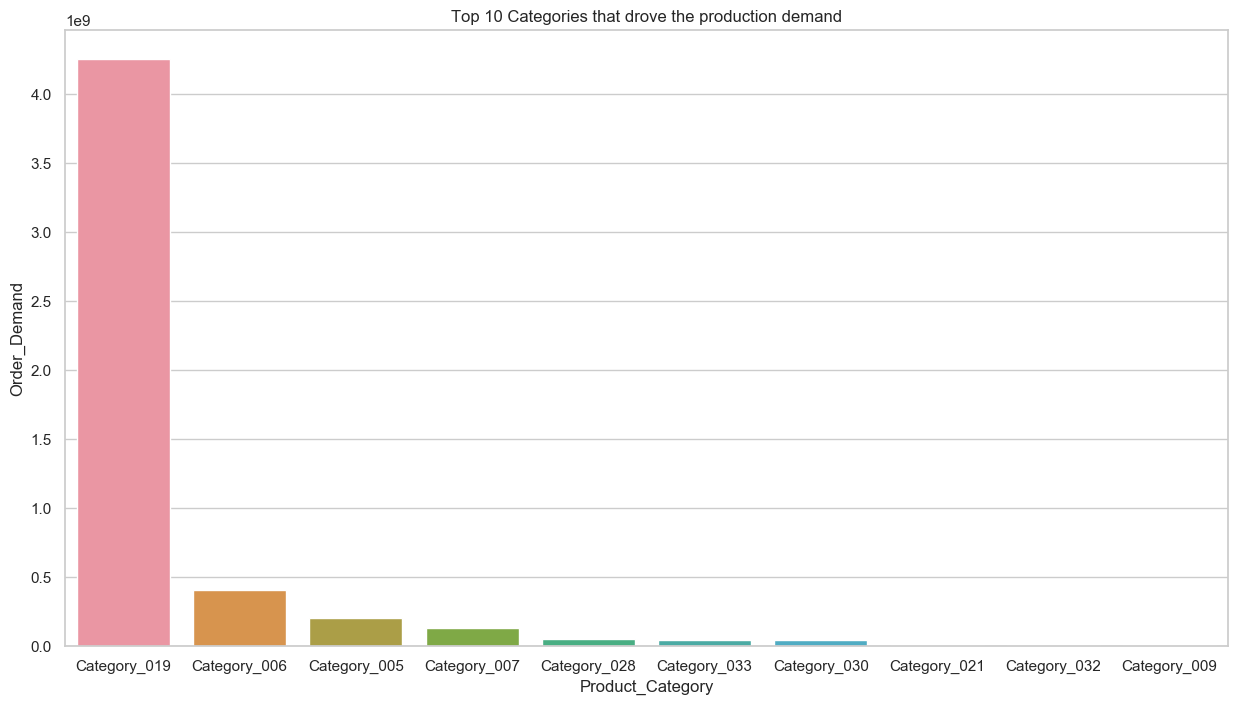

In [9]:
plt.figure(figsize = (15,8))
plt.title("Top 10 Categories that drove the production demand")
sns.barplot(data = top10_Cat, x = 'Product_Category', y = 'Order_Demand')

In [10]:
top10_prod = df.groupby(['Product_Code'], as_index = False)[['Order_Demand']].sum().sort_values(by = ['Order_Demand'],ascending = False)[:10]
top10_prod # product 1359

,Product_Code,Order_Demand
1348,Product_1359,472474000
1237,Product_1248,289117000
82,Product_0083,210651000
1330,Product_1341,169777000
1284,Product_1295,123303000
1230,Product_1241,117741000
1234,Product_1245,103537000
1275,Product_1286,101566400
1421,Product_1432,97385000
1263,Product_1274,92831000


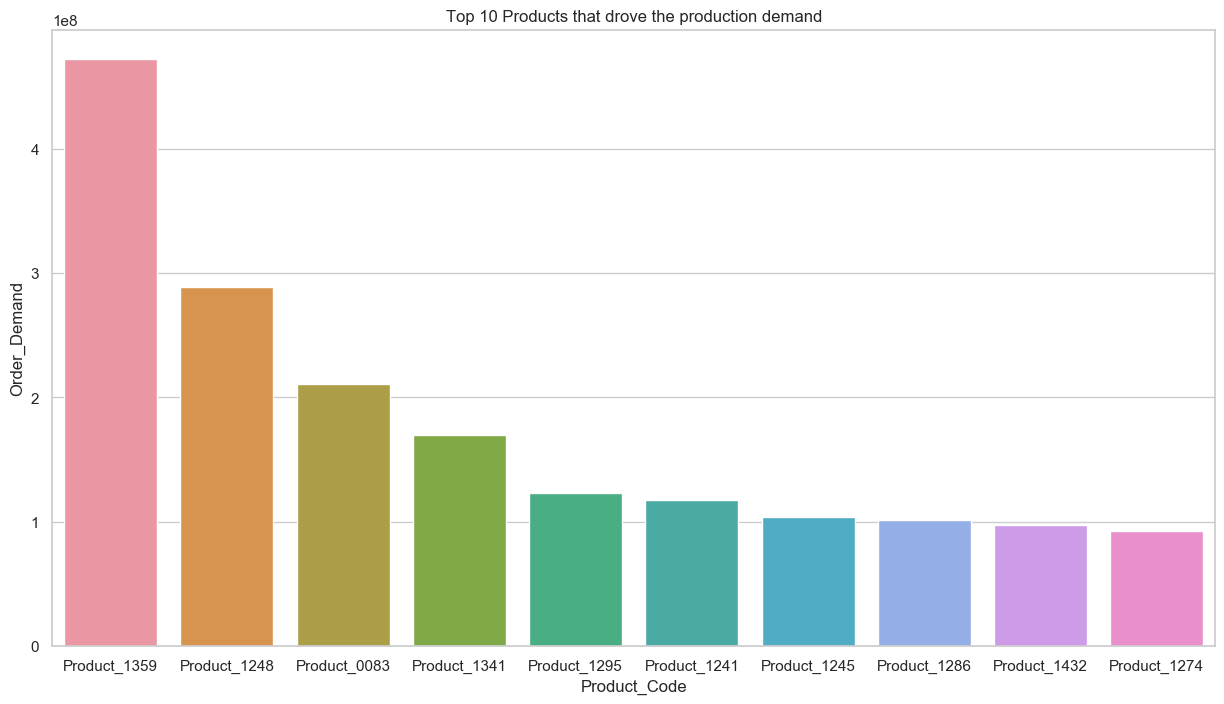

In [11]:
plt.figure(figsize = (15,8))
plt.title('Top 10 Products that drove the production demand')
sns.barplot(data = top10_prod, x = 'Product_Code', y = 'Order_Demand')

In [12]:
wh = df.groupby(['Warehouse',], as_index = False)[['Order_Demand']].sum()
wh

,Warehouse,Order_Demand
0,Whse_A,159036821
1,Whse_C,585071404
2,Whse_J,3363200396
3,Whse_S,1038024700


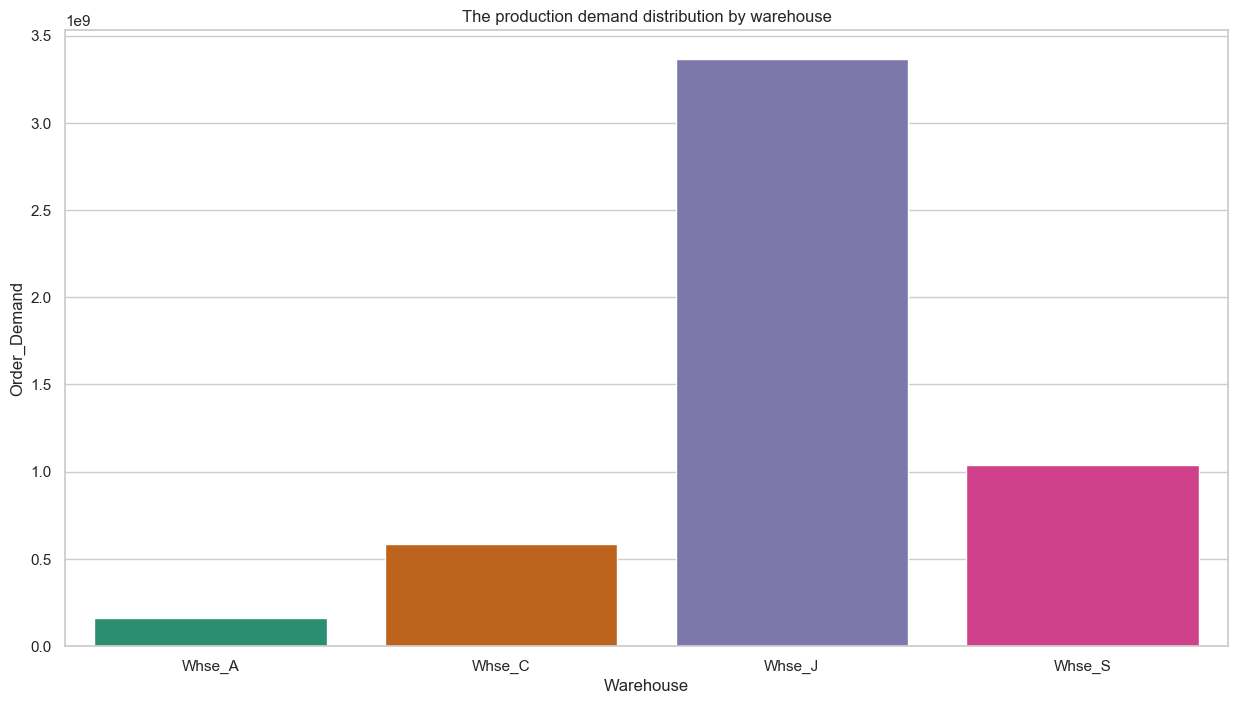

In [13]:
plt.figure(figsize = (15,8))
plt.title('The production demand distribution by warehouse')
sns.barplot(data = wh, x = 'Warehouse', y = 'Order_Demand')

There are significantly more demand order to warehouse Whse_J than the others

In [14]:
wh = df.groupby(['Warehouse', 'Date'], as_index = False)[['Order_Demand']].sum()
wh

,Warehouse,Date,Order_Demand
0,Whse_A,2011-01-08,2
1,Whse_A,2011-05-31,108
2,Whse_A,2011-11-04,500
3,Whse_A,2011-11-18,4001
4,Whse_A,2011-11-21,110
...,...,...,...
5907,Whse_S,2016-12-28,609080
5908,Whse_S,2016-12-29,346256
5909,Whse_S,2016-12-30,590180
5910,Whse_S,2017-01-02,70


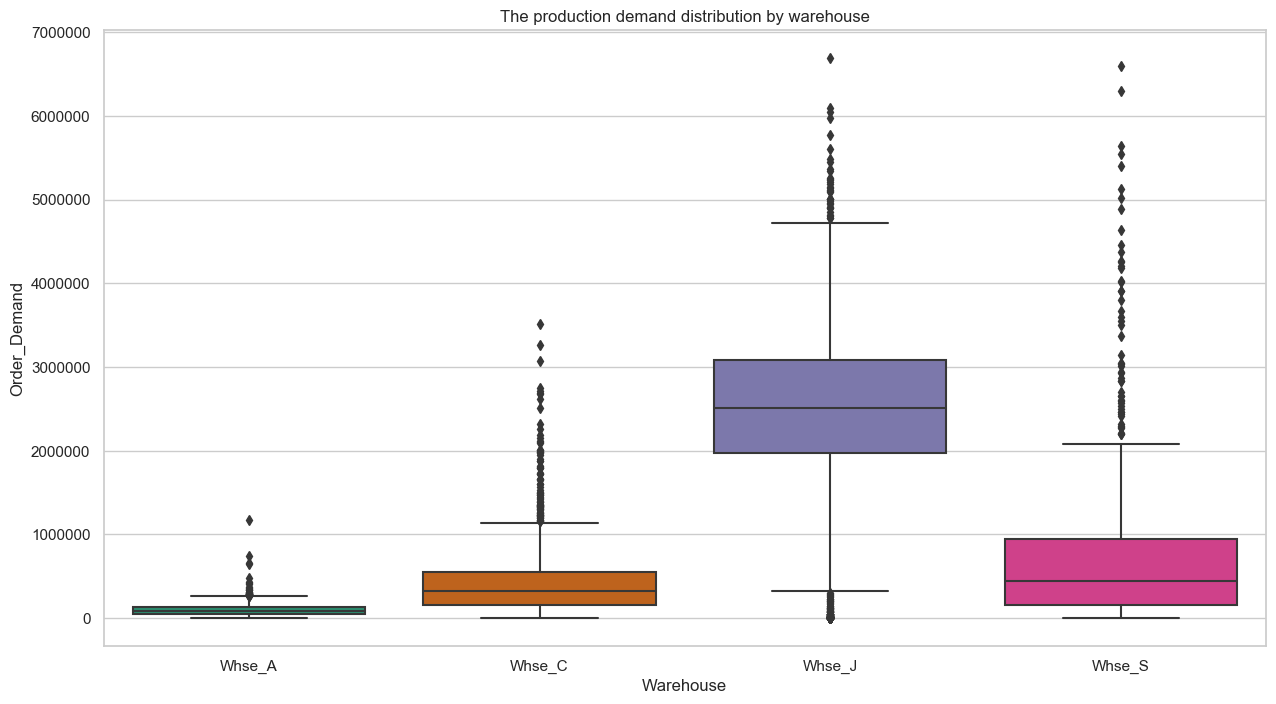

In [15]:
plt.figure(figsize = (15,8))
plt.title('The production demand distribution by warehouse')
sns.boxplot(data = wh, x = 'Warehouse', y = 'Order_Demand')

### Time-series insights
* Are there missing dates?
* Are all dates valid?
* What is the seasonability decomposition?


In [16]:
missing_dates = df[df.Date.isnull()]
missing_dates.groupby(['Warehouse', 'Product_Category'],\
                      as_index = False).agg({'Order_Demand':sum, 'Product_Code': pd.Series.nunique})

,Warehouse,Product_Category,Order_Demand,Product_Code
0,Whse_A,Category_005,6800,2
1,Whse_A,Category_006,8000,1
2,Whse_A,Category_019,11048348,61
3,Whse_A,Category_021,90,3
4,Whse_A,Category_026,1124,1
5,Whse_A,Category_028,94758,12
6,Whse_A,Category_031,270,2


In [17]:
missing_dates.groupby(['Warehouse'], as_index = False).agg({'Order_Demand':sum})

,Warehouse,Order_Demand
0,Whse_A,11159390


In [18]:
not_missing_dates = df[df.Date.notnull()]
# missing_dates.head()
not_missing_dates.groupby(['Warehouse'], as_index = False).agg({'Order_Demand':sum})

,Warehouse,Order_Demand
0,Whse_A,147877431
1,Whse_C,585071404
2,Whse_J,3363200396
3,Whse_S,1038024700


In [19]:
print("Time ranges from %s to %s" %(df['Date'].min(), df['Date'].max()))

Time ranges from 2011-01-08 00:00:00 to 2017-01-09 00:00:00


<ipython-input-20-8d4c3e18e202>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_missing_dates['Demand_Month'] = not_missing_dates.Date.dt.strftime('%Y-%m')


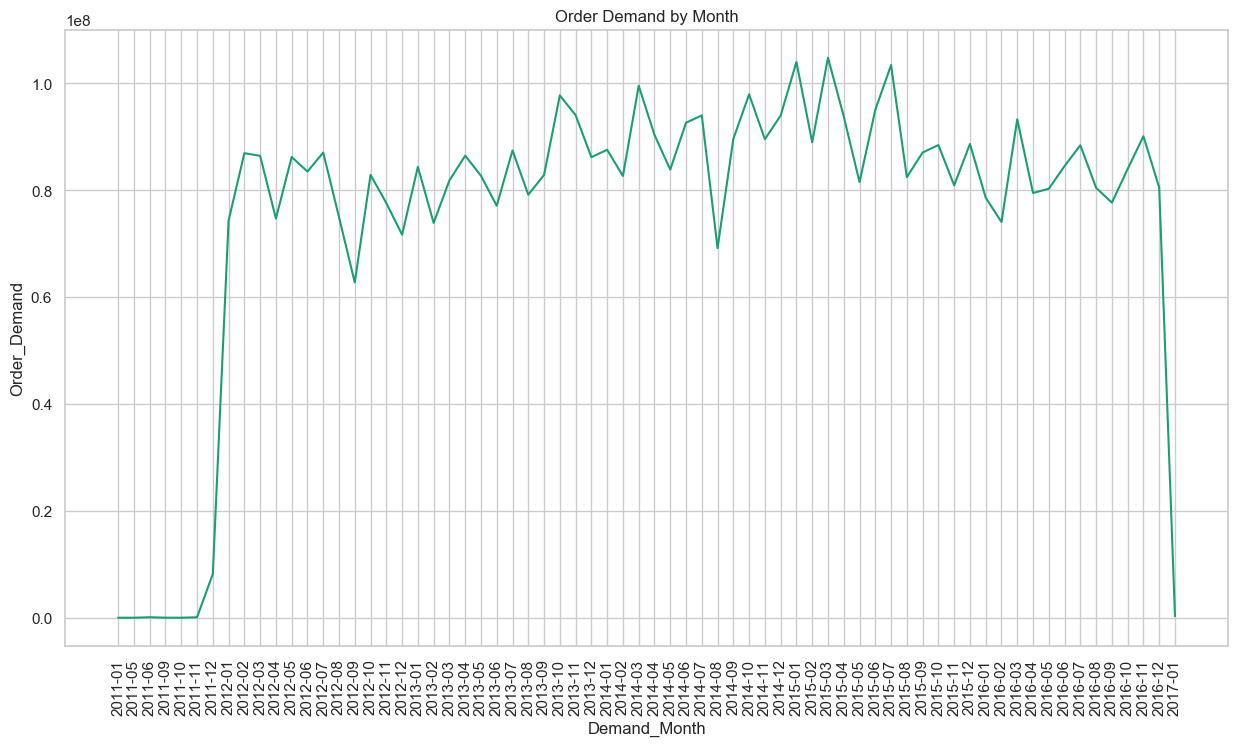

In [20]:
not_missing_dates['Demand_Month'] = not_missing_dates.Date.dt.strftime('%Y-%m')
demand = not_missing_dates.groupby(['Demand_Month'], as_index = False)[['Order_Demand']].sum()
plt.figure(figsize = (15,8))
plt.xticks(rotation=90)
plt.title('Order Demand by Month')
sns.lineplot(data = demand, x = "Demand_Month", y = 'Order_Demand')

We noticed that we have reasonable data from 2012 to 2016 so we will filter out data for that period of time

## Forecast model

### Theory
* This data shows more than 10000 missing values in date. In order to make sense/forecast order demand by time, we need to remove those missing values and focus on the one that is not null
* Even though we sum up the order demand by month, we still see some months in 2011 have no data or the demand = 0. It doesn't add up much to the insight to record demand of 0 in the table so we are going to remove them as well
* The order demand fluatated significantly on a daily basis so in order to smoothen the votality, we will handle the data on a  monthly basis
* The idea is to forecast order demand for the next year (2018), using 4 years of data to train and 1 year of data to validate
* Using ARIMA, prophet model to see which model perform better than the other

In [22]:
not_missing_dates.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Demand_Month
0,Product_0993,Whse_J,Category_028,2012-07-27,100,2012-07
1,Product_0979,Whse_J,Category_028,2012-01-19,500,2012-01
2,Product_0979,Whse_J,Category_028,2012-02-03,500,2012-02
3,Product_0979,Whse_J,Category_028,2012-02-09,500,2012-02
4,Product_0979,Whse_J,Category_028,2012-03-02,500,2012-03


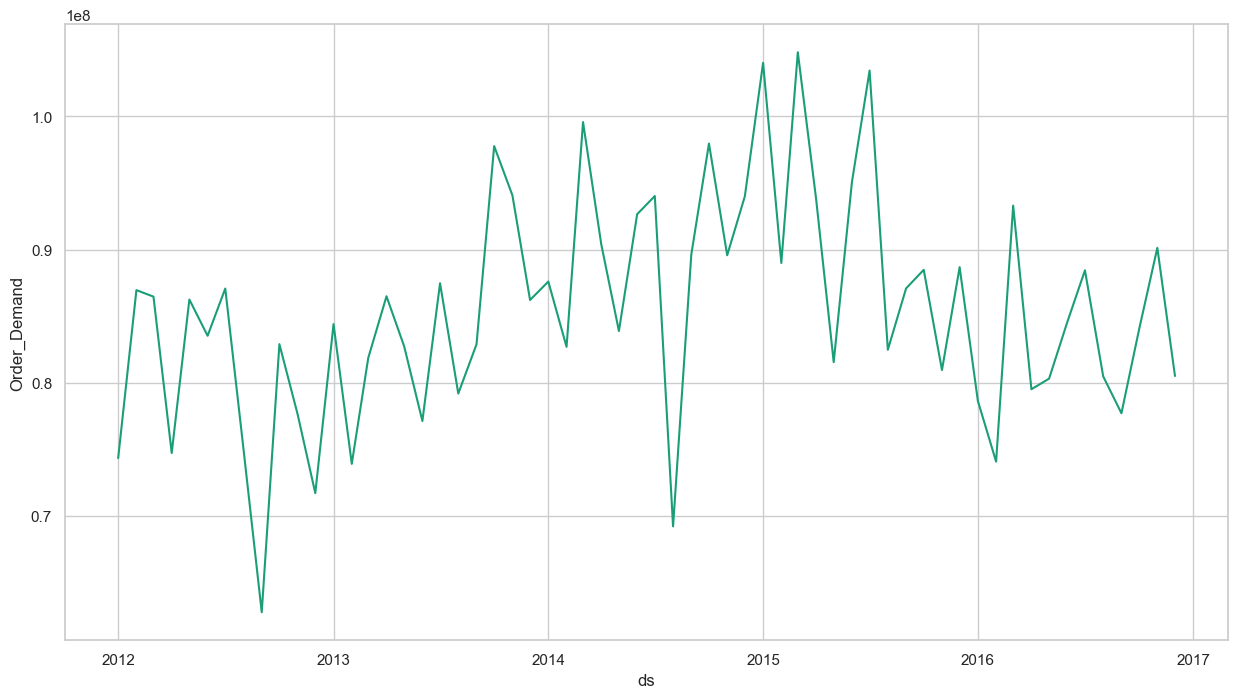

In [23]:
#have a snapshot of how the data looks like 
data = not_missing_dates[(not_missing_dates.Date>='2012-01-01')&(not_missing_dates.Date<='2016-12-31')]
data_sel = data.groupby(['Demand_Month'], as_index= False)[['Order_Demand']].sum()
data_sel['ds'] = pd.to_datetime(data_sel['Demand_Month'], infer_datetime_format=True)
# data_sel = data['Order_Demand']
# data_sel.index = data['Date']
# data_sel = data_sel.resample('M').sum()
plt.figure(figsize = (15,8))
# plt.xticks(rotation=90)
sns.lineplot(data = data_sel, x = 'ds', y = 'Order_Demand')

In [24]:
data_sel.head()

,Demand_Month,Order_Demand,ds
0,2012-01,74331037,2012-01-01
1,2012-02,86951780,2012-02-01
2,2012-03,86463212,2012-03-01
3,2012-04,74714053,2012-04-01
4,2012-05,86246051,2012-05-01


In [25]:
raw = data_sel [['Order_Demand']]
raw.index = data_sel['ds']
raw.rename(columns = {'Order_Demand': 'y'}, inplace = True)
raw.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,y
ds,
2012-01-01,74331037
2012-02-01,86951780
2012-03-01,86463212
2012-04-01,74714053
2012-05-01,86246051


* It's very important in time series data to check if the data is stationary or not. 
* The stationarity is perceived if there's no trend or seasonality (constant mean and constant variance) 

In [26]:
#check the stationarity of the data 
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determining rolling statistics
    movingAverage = timeseries.y.rolling(window = 3).mean()
    movingStd = timeseries.y.rolling(window = 3).std()
    
    #plot rolling statistics: 
    plt.figure(figsize = (15,8))
    org = plt.plot(timeseries.y, color = 'blue', label = 'Original')
    mean = plt.plot(movingAverage, color = 'red', label = 'Rolling Mean')
    sdt = plt.plot(movingStd, color = 'green', label = 'Rolling Std')
    plt.legend (loc = 'best')
    plt.title ('Rolling Mean & Standard Deviation')
    
    #Perform Dickey-Fuller test: 
    print('Results of Dickey-Fuller Test with AIC:')
    dftest = adfuller(timeseries.y, autolag = 'AIC')
    dfoutput = pd.Series (dftest [0:4],index = ['Test Statistics', 'p-value', 'Lags Used', 'Number of Obs Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
    
    if (dfoutput[0]< dfoutput[4])|(dfoutput[0]<dfoutput[5])|(dfoutput[0]<dfoutput[6]):
        print ('The data is stationary')
    else: 
        print('The data is not stationary')

Results of Dickey-Fuller Test with AIC:
Test Statistics         -2.061457
p-value                  0.260293
Lags Used                2.000000
Number of Obs Used      57.000000
Critical Value (1%)     -3.550670
Critical Value (5%)     -2.913766
Critical Value (10%)    -2.594624
dtype: float64
The data is not stationary


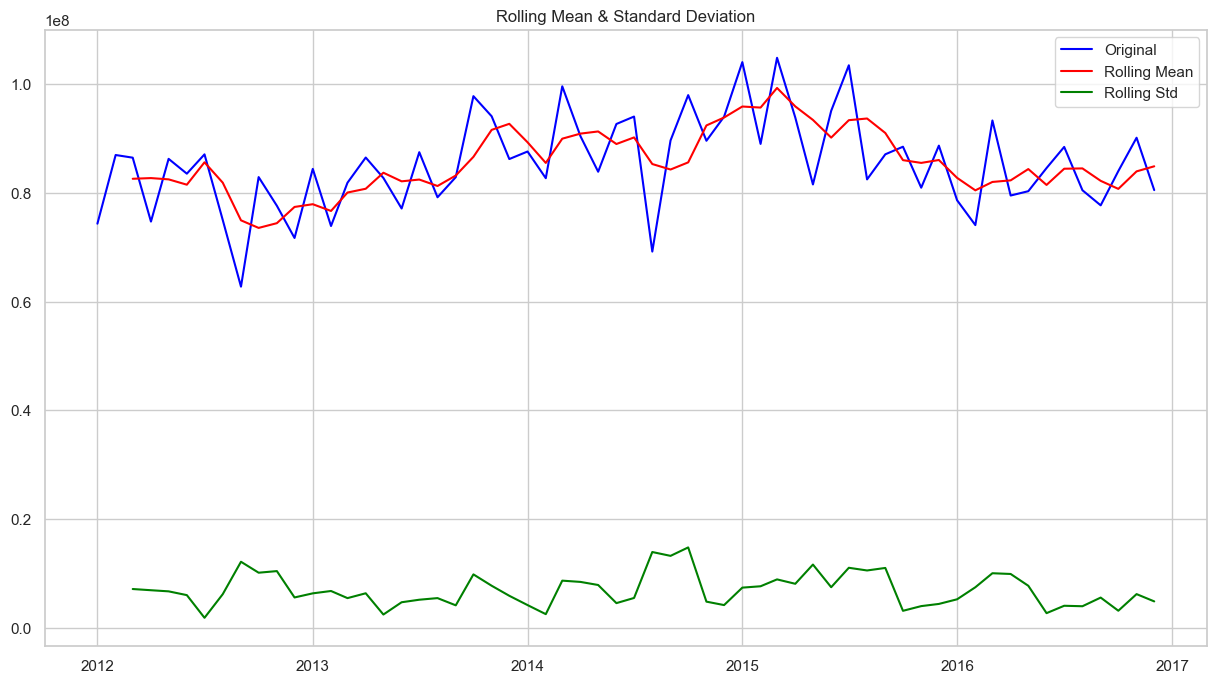

In [27]:
test_stationarity(raw)

Results of Dickey-Fuller Test with AIC:
Test Statistics         -2.716374
p-value                  0.071248
Lags Used                7.000000
Number of Obs Used      50.000000
Critical Value (1%)     -3.568486
Critical Value (5%)     -2.921360
Critical Value (10%)    -2.598662
dtype: float64
The data is stationary


<Figure size 1500x800 with 0 Axes>

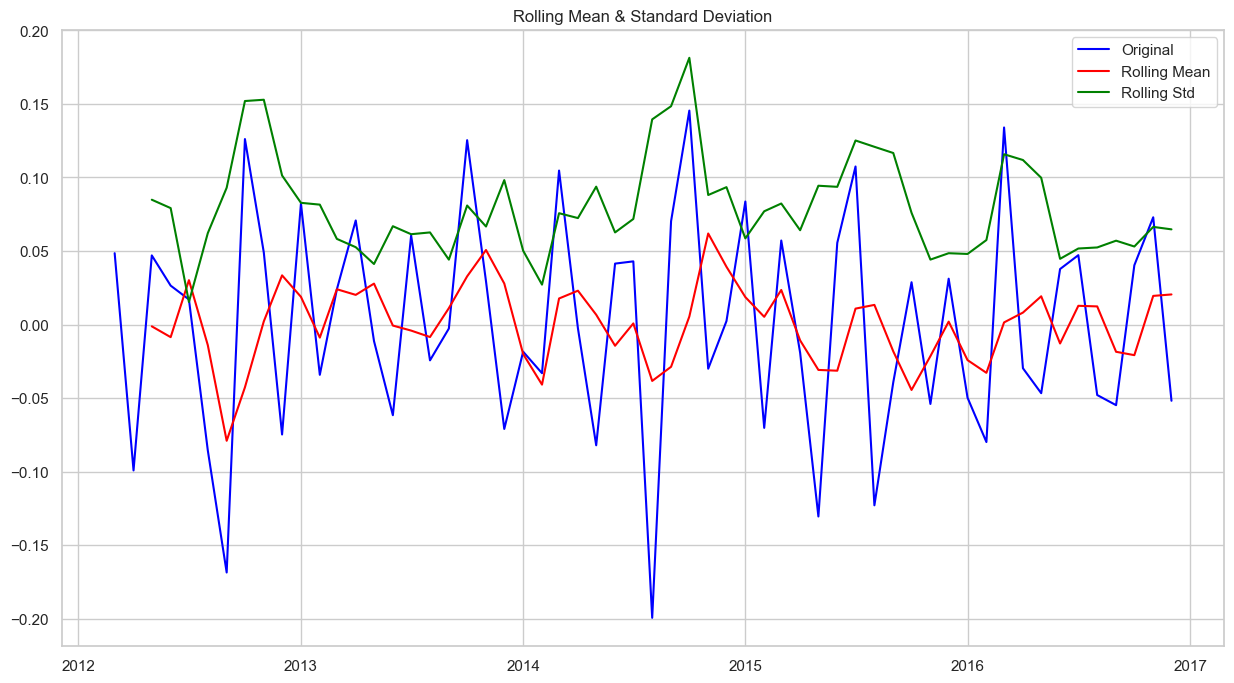

In [28]:
scaler_output = np.log(raw[['y']])
movingAverage = scaler_output.rolling(window = 3).mean()
scaler_output_log_minus_MA = (scaler_output- movingAverage).dropna()
scaler_output =pd.DataFrame(scaler_output)
# y=scaler_output
plt.figure(figsize = (15,8))
test_stationarity(scaler_output_log_minus_MA)

* Another aspect to explore in time series data is autocorrelation and partial autocorrelation
* Autocorrelation is the correlation of observations with other observations in previous time steps (lags
* The relationship between an observation in a time series with observations at prior time steps, removing the relationships of intervening observations

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


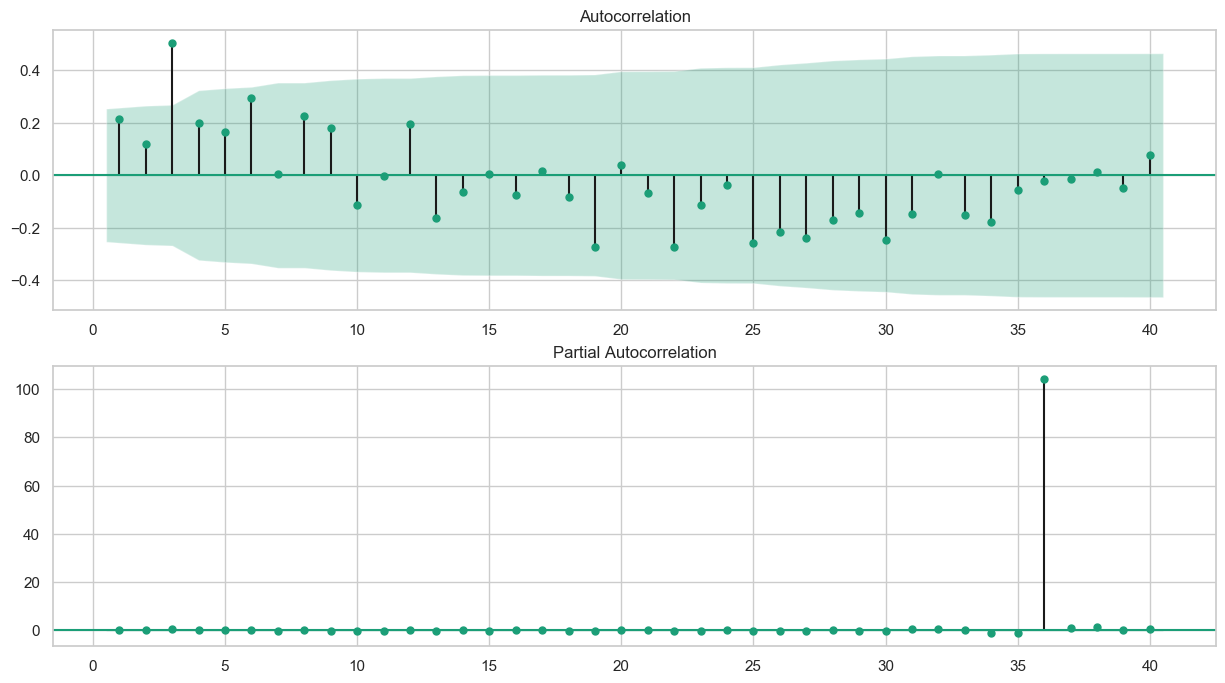

In [29]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
#Correlograms
fig,ax= plt.subplots(2,1, figsize=(15,8))
fig=sm.tsa.graphics.plot_acf(scaler_output['y'], lags= 40,zero= False, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(scaler_output['y'], lags= 40,zero= False, ax=ax[1])
plt.show()

* The lag for autocorrelation should be 3. It means that there's a correlation of order demand between the month 1 and the month 3

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

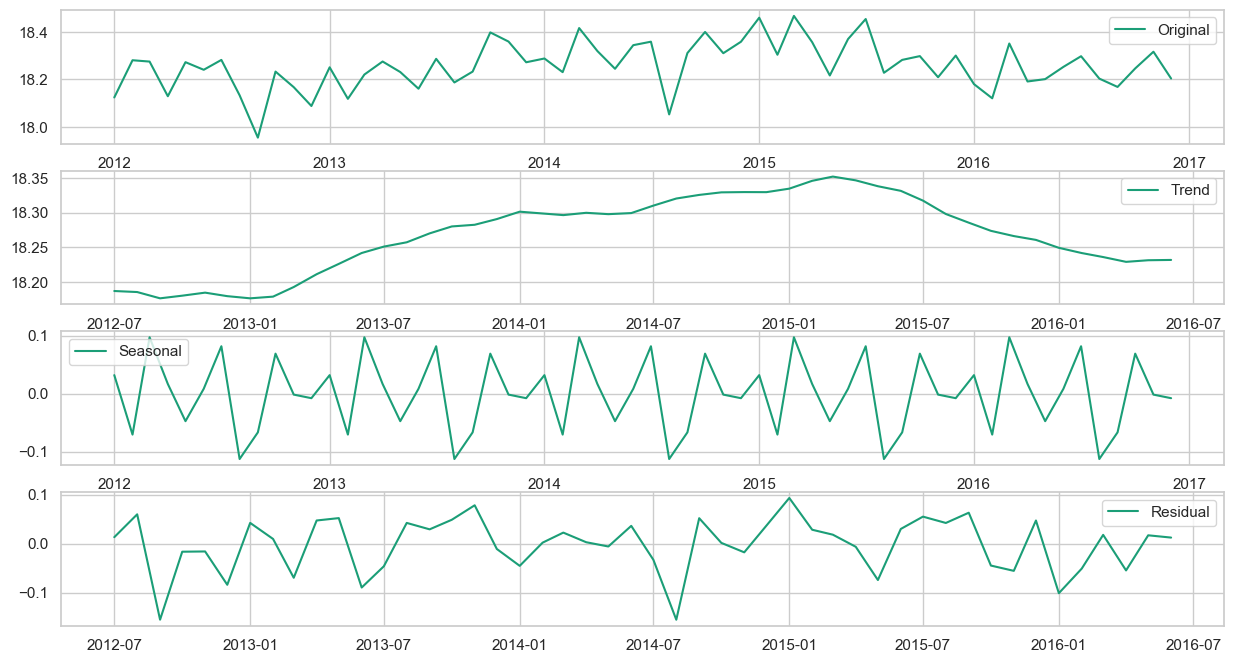

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(scaler_output)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid
plt.figure(figsize = (15,8))
plt.subplot(411)
plt.plot(scaler_output, label = 'Original')
plt.legend (loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend (loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend (loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend (loc = 'best')
plt.tight_layout

Results of Dickey-Fuller Test with AIC:
Test Statistics         -4.298289
p-value                  0.000447
Lags Used                3.000000
Number of Obs Used      44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
dtype: float64
The data is stationary


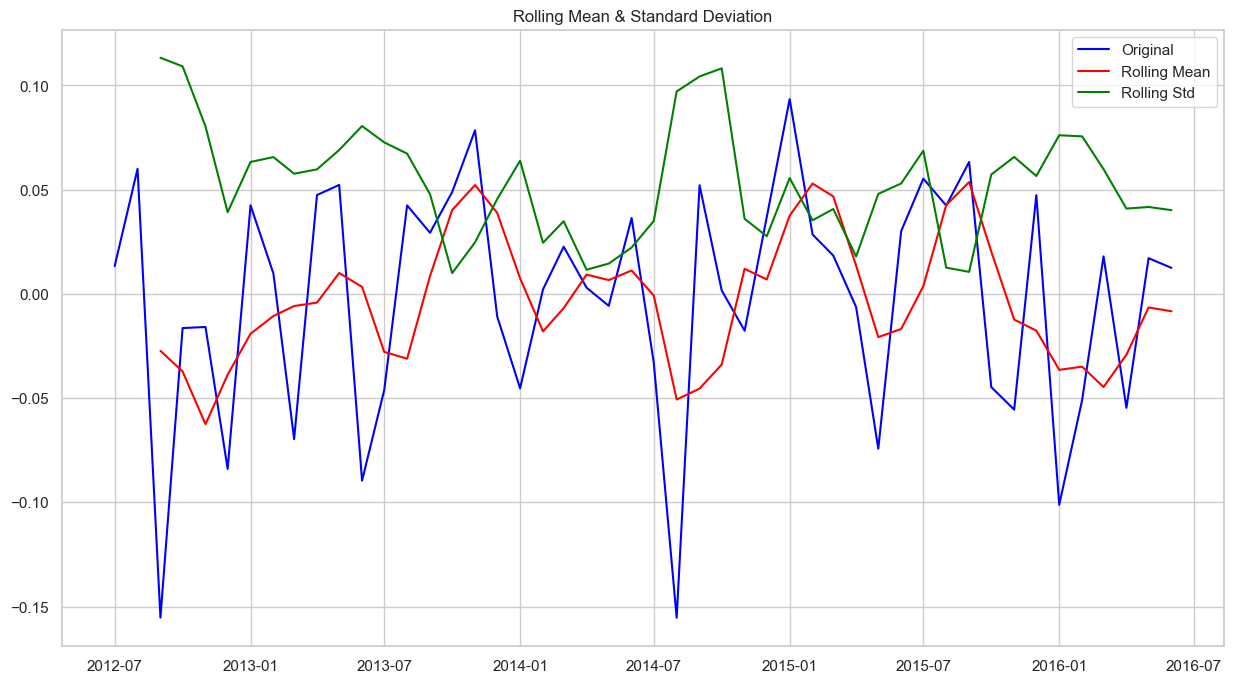

In [31]:
decomp_log = residual
decomp_log.dropna(inplace = True)
decomp_log = pd.DataFrame(decomp_log, index =decomp_log.index )
decomp_log.rename(columns = {'resid': 'y'}, inplace = True)
test_stationarity(decomp_log)

In [32]:
train_data, test_data = scaler_output[:-12], scaler_output[-12:]
print(len(train_data), len(test_data))

48 12


In [33]:
train_data.head()

,y
ds,
2012-01-01,18.124039
2012-02-01,18.280864
2012-03-01,18.275230
2012-04-01,18.129179
2012-05-01,18.272715


### Implementation
* What parameters have you consider to tune and why are those important for best-fit?

#### Training with ARIMA

In [34]:
#from pmdarima.arima import auto_arima
from pmdarima import auto_arima
arima_model = auto_arima(train_data,
                      seasonal=True,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 

# Print model summary
print(arima_model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-79.971, BIC=-68.870, Time=0.105 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-55.426, BIC=-51.726, Time=0.012 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-62.564, BIC=-57.014, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-80.394, BIC=-74.844, Time=0.061 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-57.386, BIC=-55.536, Time=0.015 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-78.434, BIC=-69.184, Time=0.106 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=-80.704, BIC=-71.453, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-78.516, BIC=-71.115, Time=0.081 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to in

In [35]:
x = arima_model.predict(n_periods=len(test_data))
x_pred = x.copy()
x_pred = [int(i) for i in x_pred]
x_pred = pd.DataFrame(x_pred)
x_pred.rename(columns = {0: 'yhat'}, inplace = True)
x_pred.index = test_data.index
x_pred.loc [x_pred.yhat<0, 'yhat'] = 0
x_pred.head()

,yhat
ds,
2016-01-01,18
2016-02-01,18
2016-03-01,18
2016-04-01,18
2016-05-01,18


In [36]:
def mape_func(forecast, test_data):
    """ This method validates MAPE of the predicted values vs. the actual values from the test set
    """
    forecast, test_data  = pd.DataFrame(forecast), pd.DataFrame(test_data)
    test_comp = pd.merge(test_data, forecast, left_index = True, right_index = True, how = 'left')
    mape = np.mean(np.abs(1 - test_comp.yhat / test_comp.y)) * 100
    return mape

In [37]:
mape_func(x_pred, test_data)

1.2486771061365838

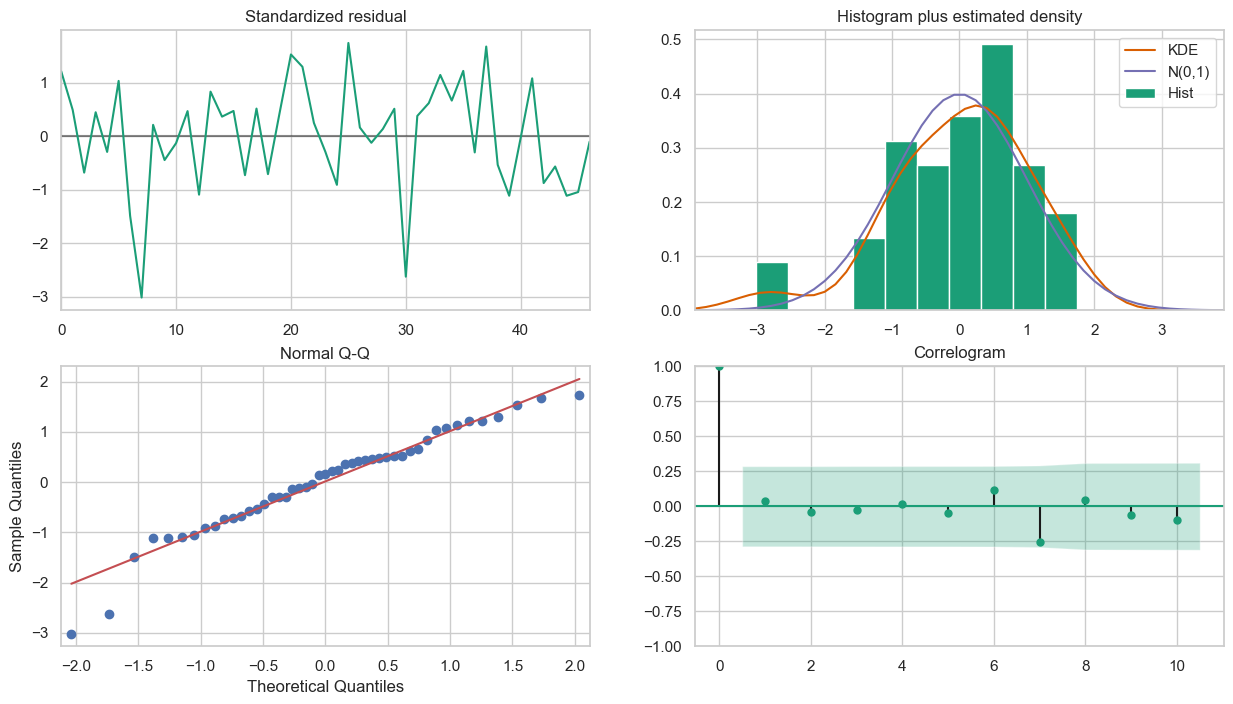

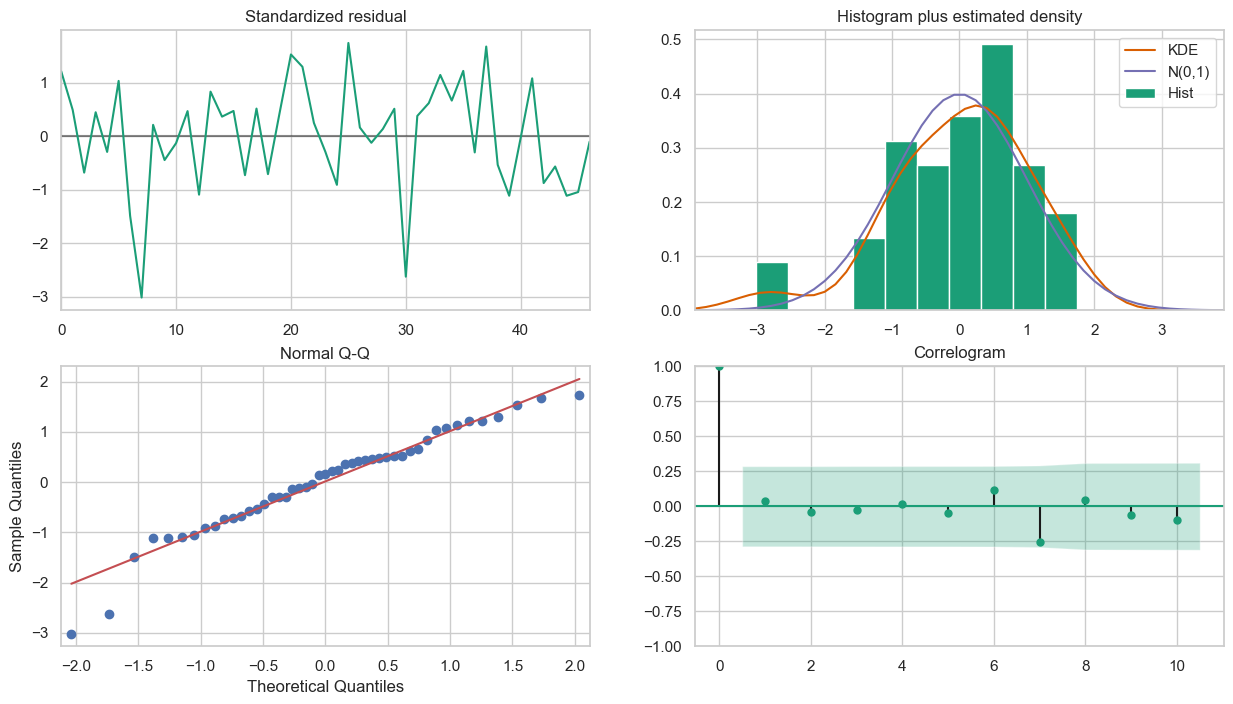

In [38]:
results = arima_model.fit(train_data)
results.plot_diagnostics(figsize=(15, 8))

#### Forecasting with Prophet

In [40]:
train_pr, test_pr =  train_data.reset_index(), test_data.reset_index()
print('Train %d, Test %d' % (len(train_pr), len(test_pr)))

Train 48, Test 12


Text(0.5, 1.0, 'Demand distribution over the period 2012-2016')

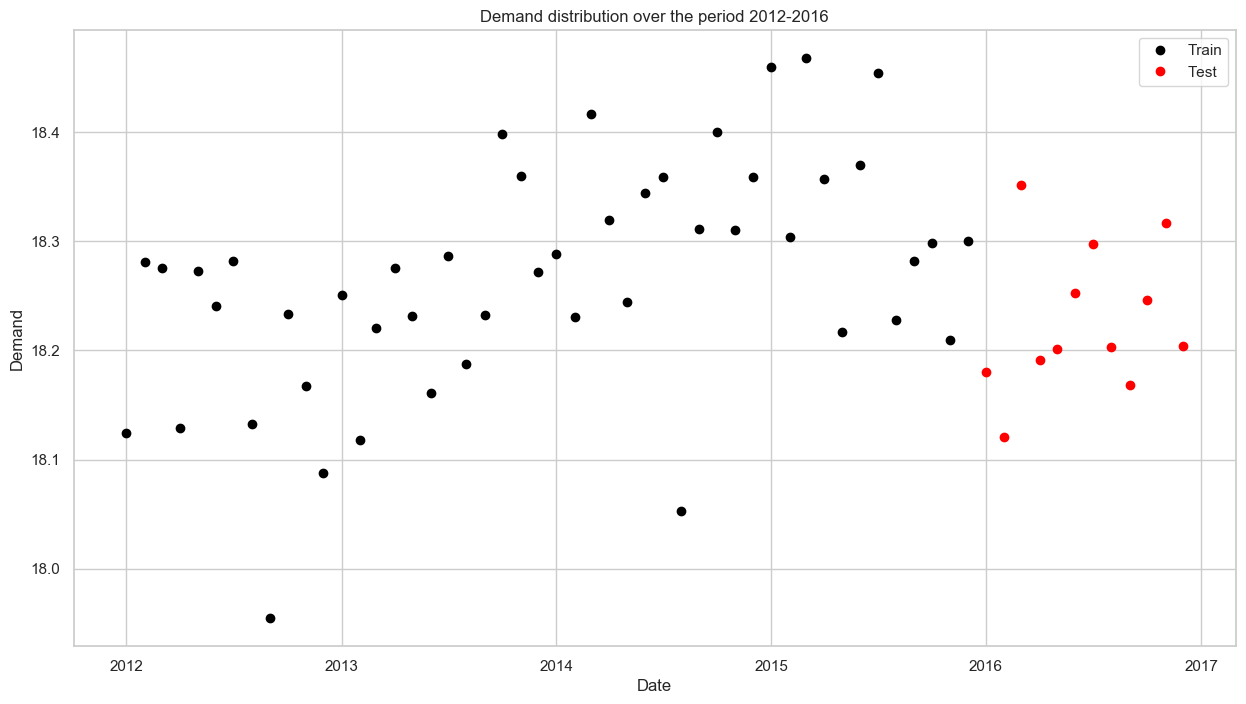

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(train_pr['ds'], train_pr['y'], linestyle='None', marker='o', color='black', label='Train')
ax.plot(test_pr['ds'], test_pr['y'], linestyle='None', marker='o', color='red', label='Test')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.title ('Demand distribution over the period 2012-2016')

In [42]:
model=Prophet(growth='linear',n_changepoints=25, changepoint_range=0.8,yearly_seasonality=True,\
              weekly_seasonality= True,daily_seasonality= False,seasonality_mode='additive',\
              changepoint_prior_scale= 0.001,interval_width=0.8)
    
model.fit(train_pr)
future = model.make_future_dataframe(periods=len(test_pr),freq="M")
forecast = model.predict(future)

#mean absolute percentage error
error = mape_func(forecast,test_pr)
print(error)

0.3778359899964898


The error rate from Prophet model is less than that of ARIMA model so we're going to use Prophet model to forecast order demand for the next year (2018)

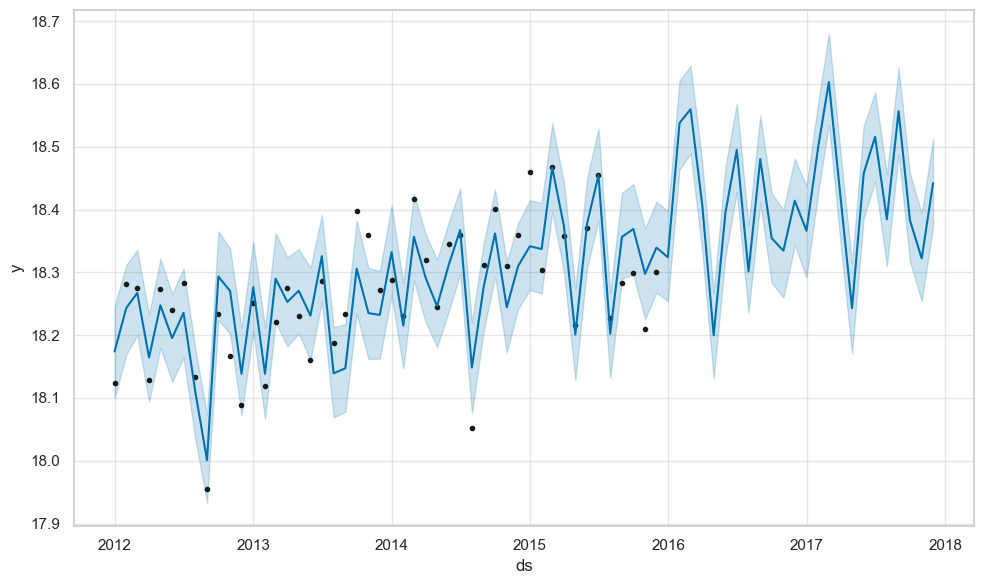

In [44]:
future_sel = model.make_future_dataframe(periods=len(test_pr)+12,freq="M")
forecast_sel = model.predict(future_sel)
fig = model.plot(forecast_sel)

In [46]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
55,2016-07-31,18.410031,18.227041,18.371924,18.410030,18.410031,-0.108615,-0.108615,-0.108615,0.003525,0.003525,0.003525,-0.112140,-0.112140,-0.112140,0.0,0.0,0.0,18.301415
56,2016-08-31,18.414273,18.414717,18.546894,18.414272,18.414273,0.066135,0.066135,0.066135,0.030765,0.030765,0.030765,0.035369,0.035369,0.035369,0.0,0.0,0.0,18.480407
57,2016-09-30,18.418378,18.277693,18.422176,18.418378,18.418379,-0.063933,-0.063933,-0.063933,-0.039124,-0.039124,-0.039124,-0.024809,-0.024809,-0.024809,0.0,0.0,0.0,18.354445
58,2016-10-31,18.422621,18.263399,18.408779,18.422620,18.422621,-0.088218,-0.088218,-0.088218,0.030439,0.030439,0.030439,-0.118657,-0.118657,-0.118657,0.0,0.0,0.0,18.334403
59,2016-11-30,18.426726,18.341062,18.483622,18.426725,18.426727,-0.012692,-0.012692,-0.012692,0.030765,0.030765,0.030765,-0.043458,-0.043458,-0.043458,0.0,0.0,0.0,18.414034


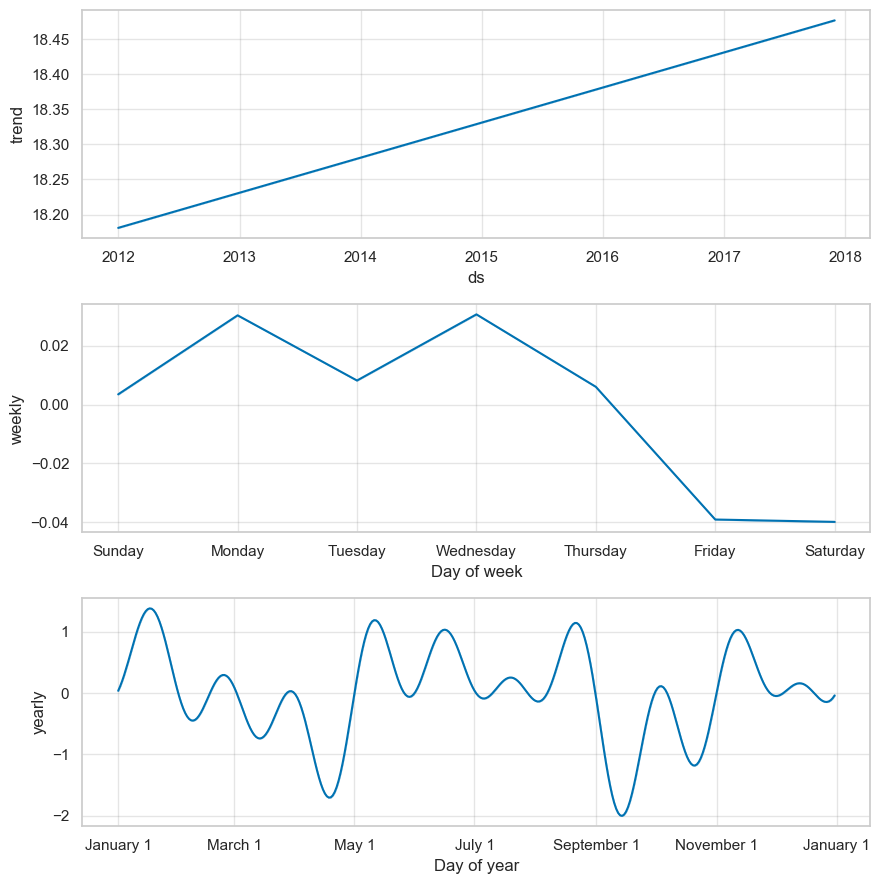

In [47]:
fig_component = model.plot_components(forecast_sel)

In [49]:
forecast_rev = np.exp(forecast_sel.yhat)
forecast_rev = pd.DataFrame(forecast_rev)
forecast_rev['date'] = forecast_sel.ds
forecast_rev['yhat'] = forecast_rev['yhat'].astype(int)
forecast_rev.tail()


,yhat,date
67,96436071,2017-07-31
68,114557269,2017-08-31
69,96281137,2017-09-30
70,90610980,2017-10-31
71,102167755,2017-11-30


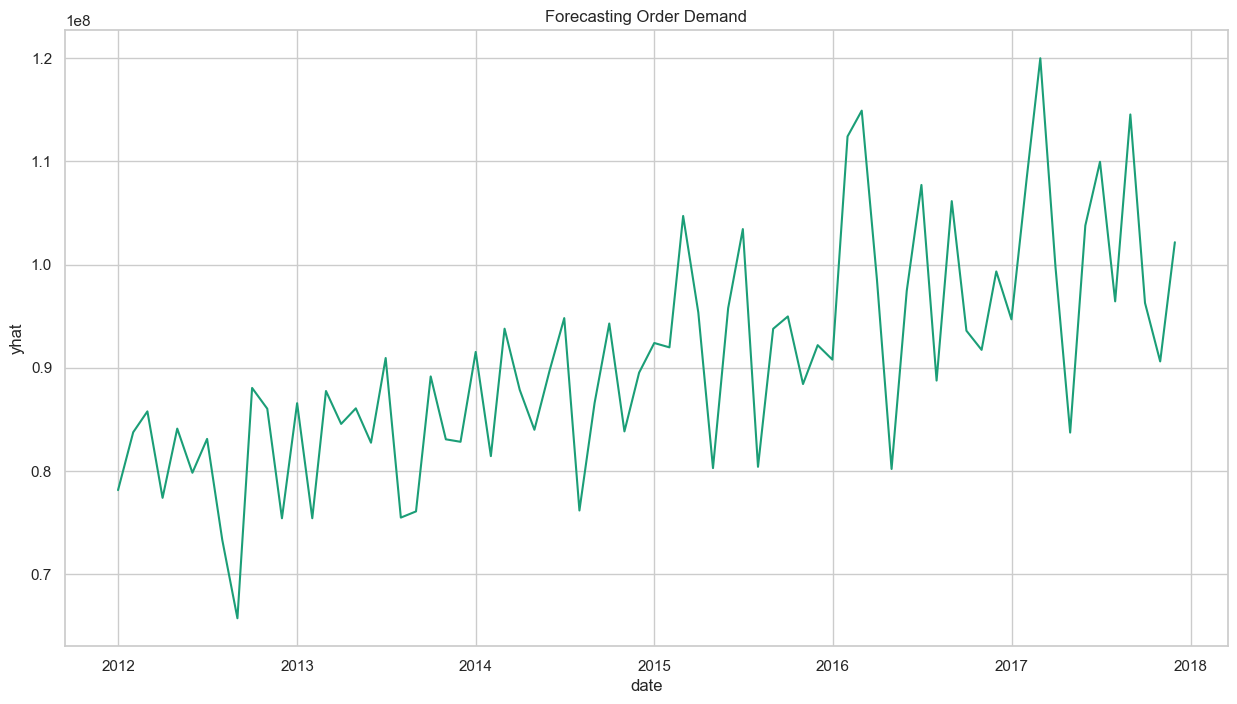

In [50]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.title('Forecasting Order Demand')
sns.lineplot(data = forecast_rev, x = 'date', y = 'yhat')


#### Forecasting by Product

In [51]:
prod_sel = data.groupby(['Demand_Month', 'Product_Code'], as_index= False)[['Order_Demand']].sum()
prod_sel = prod_sel[(prod_sel.Product_Code =='Product_1359')|(prod_sel.Product_Code =='Product_1248')|(prod_sel.Product_Code =='Product_0083')]
prod_sel['ds'] = pd.to_datetime(prod_sel['Demand_Month'], infer_datetime_format=True)
prod_sel.head()

,Demand_Month,Product_Code,Order_Demand,ds
63,2012-01,Product_0083,2789000,2012-01-01
944,2012-01,Product_1248,3772000,2012-01-01
1026,2012-01,Product_1359,8911000,2012-01-01
1654,2012-02,Product_0083,3682000,2012-02-01
2564,2012-02,Product_1248,6477000,2012-02-01


In [66]:
def get_data( data, product): 
    data_sel = data[data.Product_Code == product]
    data_input= data_sel[['ds']]
    data_input['y'] = np.log(data_sel['Order_Demand'])
    return data_input

def split_data(data_input, n = 12): 
    train_data = data_input[:-12]
    test_data = data_input[-12:]
    return train_data, test_data

def create_model(train_data):
    model=Prophet(growth='linear',n_changepoints=25, changepoint_range=0.8,yearly_seasonality=True,\
              weekly_seasonality= True,daily_seasonality= False,seasonality_mode='additive',\
              changepoint_prior_scale= 0.001,interval_width=0.8)
    
    model.fit(train_data)
    return model 

def get_error(model, test_data,  freq = 'M'): 
    future = model.make_future_dataframe(periods=len(test_data),freq=freq)
    forecast = model.predict(future)
    #mean absolute percentage error
    error = mape_func(forecast,test_data)
    print(error)

def get_forecast(model, test_data,  freq = 'M'): 
    future = model.make_future_dataframe(periods=len(test_data)+12,freq=freq)
    forecast = model.predict(future)
    return forecast

def plot_chart(model, forecast, product):
    fig = model.plot(forecast)
    fig_component = model.plot_components(forecast)

def rev_forecast(forecast): 
    forecast_rev = np.exp(forecast.yhat)
    forecast_rev = pd.DataFrame(forecast_rev)
    forecast_rev['date'] = forecast.ds
    forecast_rev['yhat'] = forecast_rev['yhat'].astype(int)
    return forecast_rev

Product_0083


<ipython-input-66-f8f88fa71e96>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_input['y'] = np.log(data_sel['Order_Demand'])


Forecasting for Product_0083
Product_1248


<ipython-input-66-f8f88fa71e96>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_input['y'] = np.log(data_sel['Order_Demand'])


Forecasting for Product_1248
Product_1359


<ipython-input-66-f8f88fa71e96>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_input['y'] = np.log(data_sel['Order_Demand'])


Forecasting for Product_1359


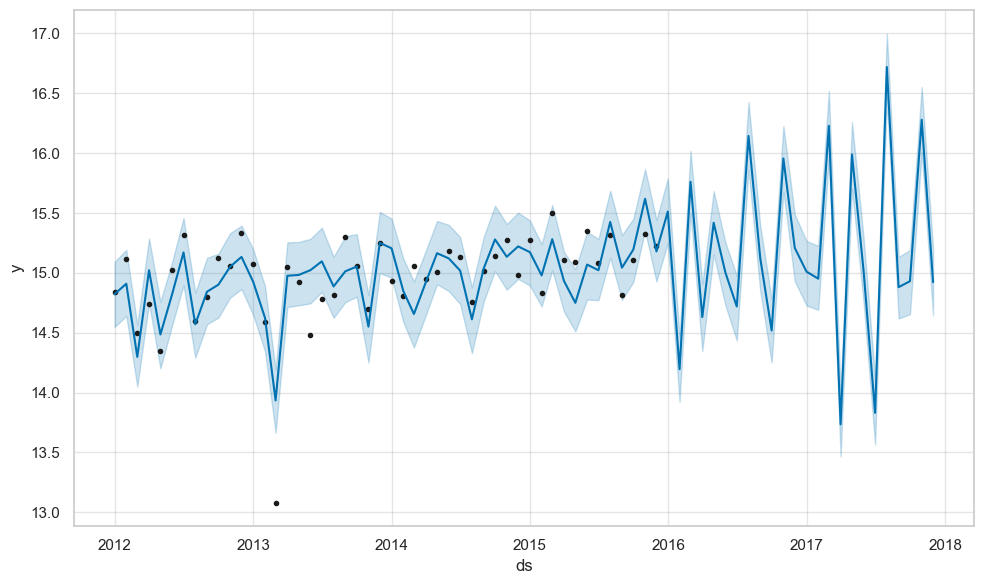

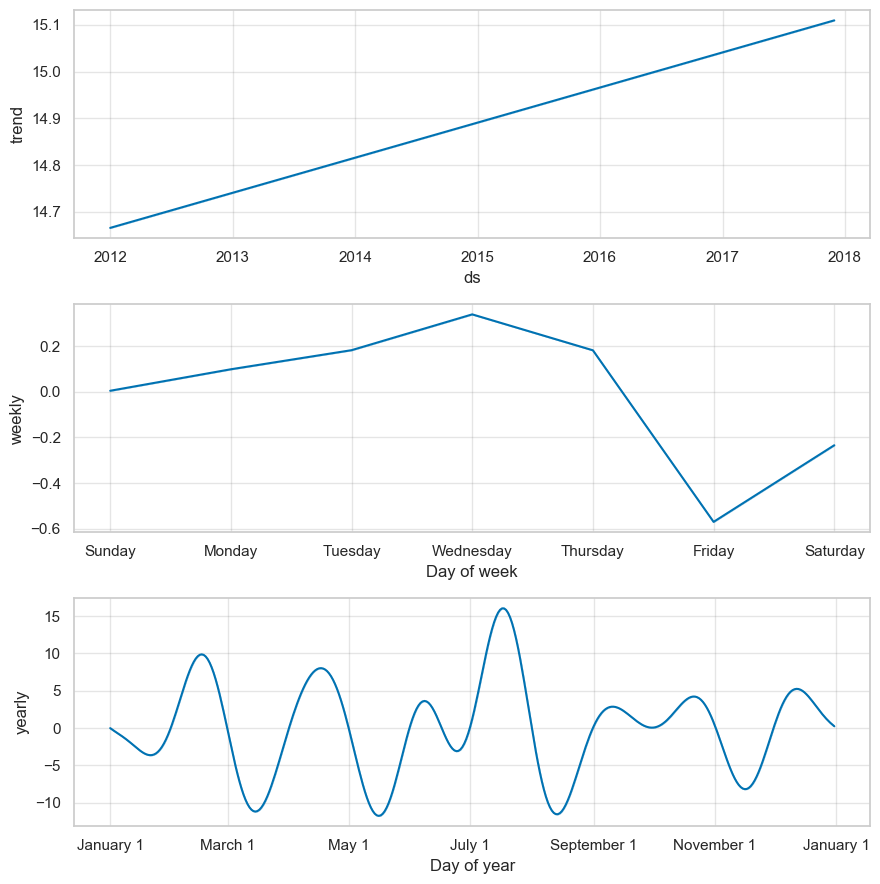

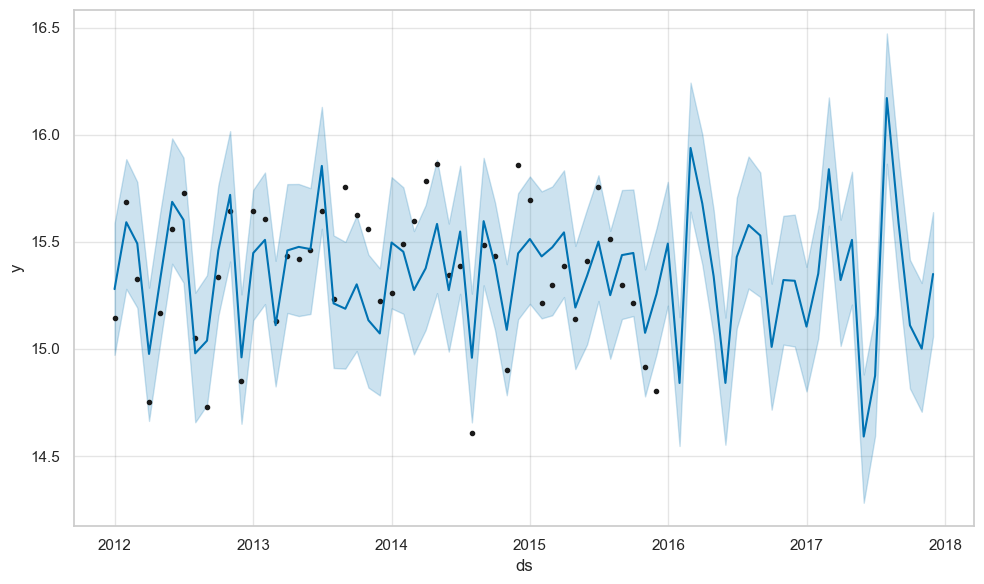

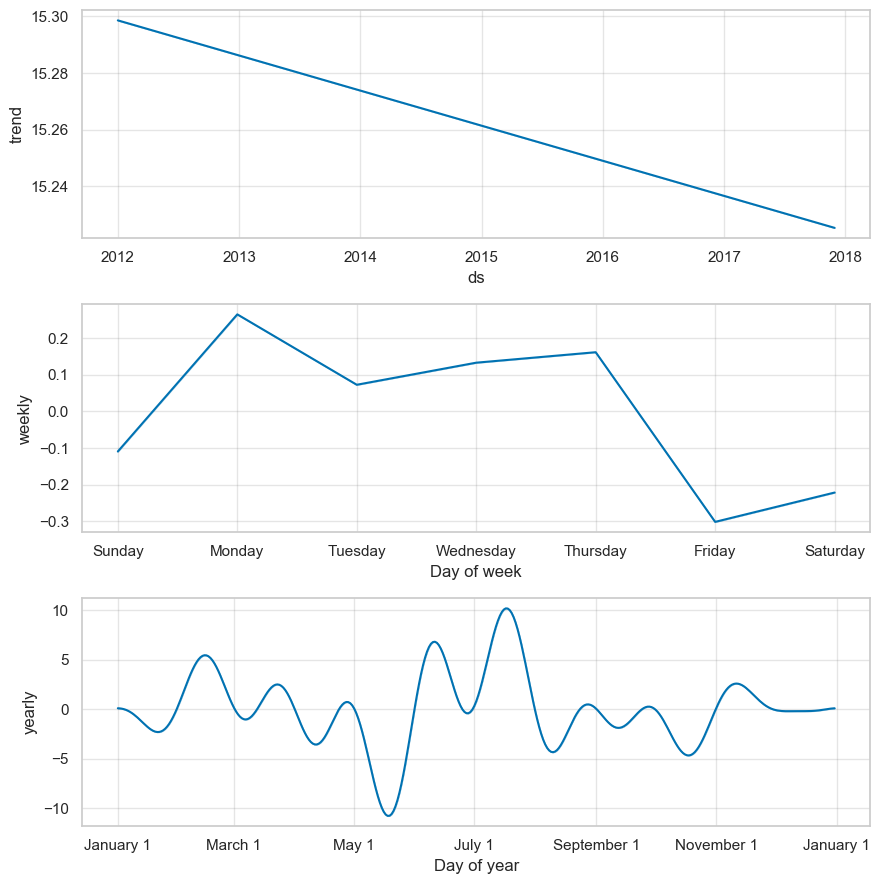

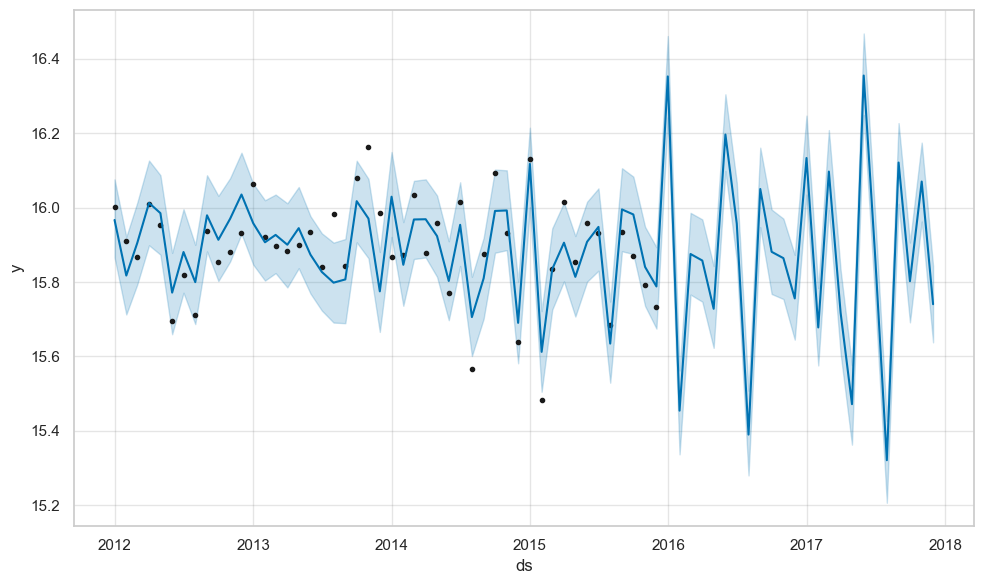

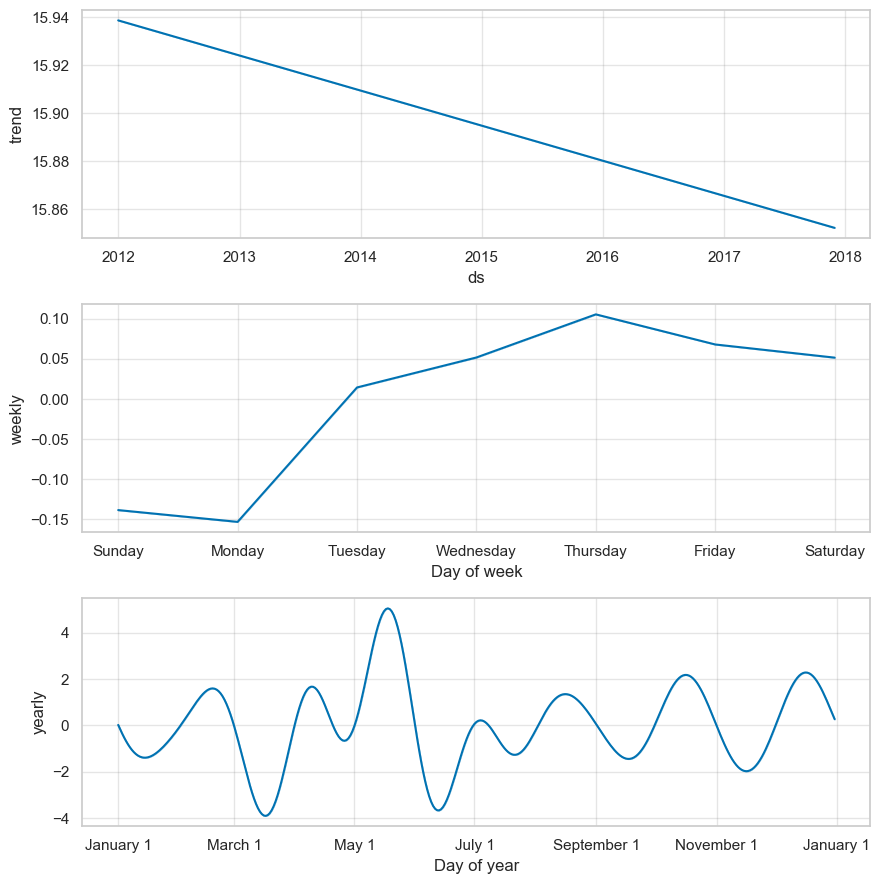

In [67]:
forecast_data = {}
for product in prod_sel.Product_Code.unique().tolist(): 
    print(product)
    data = get_data(prod_sel, product)
    train_data, test_data = split_data(data)
    model = create_model(train_data)
#     get_error(model, test_data)
    forecast = get_forecast(model, test_data)
    print('Forecasting for %s'%(product))
    plot_chart(model, forecast, product)
    forecast_rev = rev_forecast(forecast)
    forecast_data[product] = forecast_rev


In [82]:
count= 0
products = pd.DataFrame()
data_prod = pd.DataFrame()
for product in prod_sel.Product_Code.unique().tolist():
    count += 1
#     print(product, count)
    data_prod = forecast_data.get(product)
    data_prod['Product_Code'] = product
    
    if count == 1: 
        products = data_prod
    else: 
        products = pd.concat([products,data_prod])
products.tail()

,yhat,date,Product_Code
67,4507722,2017-07-31,Product_1359
68,10028993,2017-08-31,Product_1359
69,7291497,2017-09-30,Product_1359
70,9529597,2017-10-31,Product_1359
71,6854429,2017-11-30,Product_1359


In [83]:
products.Product_Code.unique().tolist()

['Product_0083', 'Product_1248', 'Product_1359']

In [84]:
products.to_csv('product_forecast.csv', index = False)